In [ ]:
!pip install --upgrade pip setuptools wheel


In [ ]:
!pip install --upgrade numpy==1.23.5


In [ ]:
!pip install --no-binary scikit-surprise scikit-surprise


In [ ]:
import sys
import numpy as np

print("Python version:", sys.version)
print("NumPy version:", np.__version__)

import surprise
from surprise import Dataset, Reader, SVD
print("scikit-surprise imported successfully!")


Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
NumPy version: 1.23.5
scikit-surprise imported successfully!


In [ ]:
!pip install kaggle

# Make a directory for your Kaggle configuration (if it doesn't exist)
!mkdir -p ~/.kaggle

# Copy your kaggle.json to this directory
!cp /content/kaggle.json ~/.kaggle/

# Change permissions to secure your file
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d netflix-inc/netflix-prize-data -p /content/netflix_data --unzip

Dataset URL: https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data
License(s): other


In [ ]:
!ls /content/netflix_data


combined_data_1.txt  combined_data_3.txt  movie_titles.csv  qualifying.txt
combined_data_2.txt  combined_data_4.txt  probe.txt	    README


In [ ]:
import pandas as pd

file_path = '/content/netflix_data/combined_data_1.txt'
data = []
with open(file_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            current_movie_id = int(line[:-1])
        else:
            customer_id, rating, date = line.split(',')
            data.append([current_movie_id, int(customer_id), int(rating), date])

df = pd.DataFrame(data, columns=['MovieID', 'UserID', 'Rating', 'Date'])
print(df.head())


   MovieID   UserID  Rating        Date
0        1  1488844       3  2005-09-06
1        1   822109       5  2005-05-13
2        1   885013       4  2005-10-19
3        1    30878       4  2005-12-26
4        1   823519       3  2004-05-03


In [ ]:
# Count unique movies, users, and total ratings
num_movies = df['MovieID'].nunique()
num_users = df['UserID'].nunique()
num_ratings = len(df)

print("Number of unique movies:", num_movies)
print("Number of unique users:", num_users)
print("Total number of ratings:", num_ratings)


Number of unique movies: 4499
Number of unique users: 470758
Total number of ratings: 24053764


<ipython-input-4-0192fb0706fc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis')


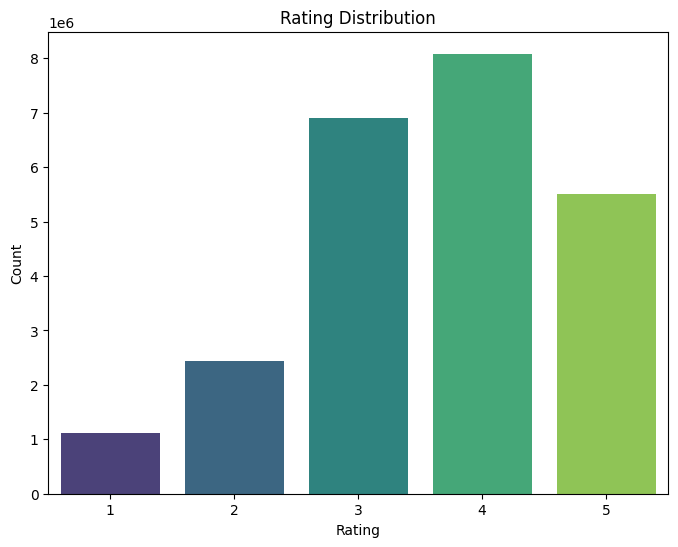

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [ ]:
# Take a sample of 100,000 ratings for faster processing
df_sample = df.sample(n=200000, random_state=42)

# Preview the sample
print(df_sample.head())


          MovieID   UserID  Rating       Date YearMonth
20520773     3894  2260145       3 2005-01-19   2005-01
15441596     2960  1934293       3 2005-03-26   2005-03
10358153     2009  2559843       3 2004-02-09   2004-02
1618777       313  1197042       5 2001-08-21   2001-08
13955499     2680   900629       2 2004-07-07   2004-07


In [ ]:
from surprise import Dataset, Reader

# Define the reader with rating scale 1 to 5. We define the range of valid ratings. Netflix uses 1 to 5 stars, so we specify that here.
reader = Reader(rating_scale=(1, 5))

# Load the dataset into surprise format
data = Dataset.load_from_df(df_sample[['UserID', 'MovieID', 'Rating']], reader)

# Build the full trainset for training
trainset = data.build_full_trainset()


In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate

# Initialize the SVD model
model = SVD()

# Evaluate the model using cross-validation
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0161  1.0186  1.0212  1.0187  0.0021  
MAE (testset)     0.8172  0.8187  0.8198  0.8186  0.0011  
Fit time          4.59    4.67    4.96    4.74    0.16    
Test time         0.59    0.52    0.52    0.54    0.04    


{'test_rmse': array([1.0160951 , 1.01864993, 1.0212342 ]),
 'test_mae': array([0.81717555, 0.81869926, 0.81981636]),
 'fit_time': (4.586117267608643, 4.67467474937439, 4.95831298828125),
 'test_time': (0.5923426151275635, 0.5170807838439941, 0.5173110961914062)}

In [ ]:
found = False

# Loop through all users in trainset
for user_id in trainset.all_users():
    raw_uid = trainset.to_raw_uid(user_id)  # string
    int_uid = int(raw_uid)  # for filtering df_sample

    # Filter for ratings by this user
    user_ratings = df_sample[(df_sample['UserID'] == int_uid) & (df_sample['Rating'] >= 4)]

    if len(user_ratings) >= 10:
        final_user_id_str = raw_uid
        final_user_id_int = int_uid
        print(f"🎯 Found user: {final_user_id_str} with {len(user_ratings)} high ratings")
        found = True
        break

if not found:
    print("❌ No user found with multiple 4+ ratings. Try increasing sample size.")


🎯 Found user: 1664010 with 30 high ratings


In [ ]:
liked_with_titles = pd.merge(user_ratings, movie_titles, on='MovieID', how='left')

print(f"\n🎬 Movies liked by user {final_user_id_str}:")
print(liked_with_titles[['MovieID', 'Title', 'Rating']].head(10))



🎬 Movies liked by user 1664010:
   MovieID                                              Title  Rating
0     1217             Dragon Tales: Let's Share! Let's Play!       5
1       89                                   Chain of Command       4
2     2670                               The Eighteenth Angel       5
3     1194                                               Fall       4
4      991  Burn Up Excess: Vol. 2: Crimes and Missed Deme...       5
5     3416                            Masters of the Universe       4
6     4139                                               2LDK       4
7     4040                                  Tales of the City       5
8     1612                                          Tony Rome       5
9     2731                                          Tank Girl       5


In [ ]:
recommendations = recommend_movies_with_titles(model, trainset, final_user_id_str, movie_titles, n=10)

print(f"\n🍿 Top 10 recommended movies for user {final_user_id_str}:")
print(recommendations)



🍿 Top 10 recommended movies for user 1664010:
   MovieID                                          Title  PredictedRating
0     4306                                The Sixth Sense                5
1     3962                      Finding Nemo (Widescreen)                5
2     3864                                  Batman Begins                5
3     3290                                            NaN                5
4     2913                              Finding Neverland                5
5     2452  Lord of the Rings: The Fellowship of the Ring                5
6     2803                            Pride and Prejudice                5
7     2057             Buffy the Vampire Slayer: Season 6                5
8     4353                 Curb Your Enthusiasm: Season 3                5
9      872                                  Seven Samurai                5
